# Gmsh2OPS: Case 2

## Gmsh model

This example is based on GMSH Example [t15](https://gmsh.info/doc/texinfo/gmsh.html#t15).

<img src="assets/gmsh-t15.png" alt="t15 example" width="600">

In [10]:
import gmsh
import sys

gmsh.initialize()

# Copied from `t1.py'...
lc = 1e-2
gmsh.model.geo.addPoint(0, 0, 0, lc, 1)
gmsh.model.geo.addPoint(0.1, 0, 0, lc, 2)
gmsh.model.geo.addPoint(0.1, 0.3, 0, lc, 3)
gmsh.model.geo.addPoint(0, 0.3, 0, lc, 4)
gmsh.model.geo.addLine(1, 2, 1)
gmsh.model.geo.addLine(3, 2, 2)
gmsh.model.geo.addLine(3, 4, 3)
gmsh.model.geo.addLine(4, 1, 4)
gmsh.model.geo.addCurveLoop([4, 1, -2, 3], 1)
gmsh.model.geo.addPlaneSurface([1], 1)

# We change the mesh size to generate a coarser mesh
lc = lc * 4
gmsh.model.geo.mesh.setSize([(0, 1), (0, 2), (0, 3), (0, 4)], lc)

# We define a new point
gmsh.model.geo.addPoint(0.02, 0.02, 0.0, lc, 5)

# We have to synchronize before embedding entites:
gmsh.model.geo.synchronize()

# One can force this point to be included ("embedded") in the 2D mesh, using the
# `embed()' function:
gmsh.model.mesh.embed(0, [5], 2, 1)

# In the same way, one can use `embed()' to force a curve to be embedded in the
# 2D mesh:
gmsh.model.geo.addPoint(0.02, 0.12, 0.0, lc, 6)
gmsh.model.geo.addPoint(0.04, 0.18, 0.0, lc, 7)
gmsh.model.geo.addLine(6, 7, 5)

gmsh.model.geo.synchronize()
gmsh.model.mesh.embed(1, [5], 2, 1)

# Points and curves can also be embedded in volumes
gmsh.model.geo.extrude([(2, 1)], 0, 0, 0.1)

p = gmsh.model.geo.addPoint(0.07, 0.15, 0.025, lc)

gmsh.model.geo.synchronize()
gmsh.model.mesh.embed(0, [p], 3, 1)

gmsh.model.geo.addPoint(0.025, 0.15, 0.025, lc, p + 1)
l = gmsh.model.geo.addLine(7, p + 1)

gmsh.model.geo.synchronize()
gmsh.model.mesh.embed(1, [l], 3, 1)

# Finally, we can also embed a surface in a volume:
gmsh.model.geo.addPoint(0.02, 0.12, 0.05, lc, p + 2)
gmsh.model.geo.addPoint(0.04, 0.12, 0.05, lc, p + 3)
gmsh.model.geo.addPoint(0.04, 0.18, 0.05, lc, p + 4)
gmsh.model.geo.addPoint(0.02, 0.18, 0.05, lc, p + 5)

gmsh.model.geo.addLine(p + 2, p + 3, l + 1)
gmsh.model.geo.addLine(p + 3, p + 4, l + 2)
gmsh.model.geo.addLine(p + 4, p + 5, l + 3)
gmsh.model.geo.addLine(p + 5, p + 2, l + 4)

ll = gmsh.model.geo.addCurveLoop([l + 1, l + 2, l + 3, l + 4])
s = gmsh.model.geo.addPlaneSurface([ll])

gmsh.model.geo.synchronize()
gmsh.model.mesh.embed(2, [s], 3, 1)

# Important:
# Note that we use names to distinguish groups, so please do not overlook this!
# We use the "Boundary" group to include 1 surface, 4 lines and 4 corner points, which will later be used to specify the boundary conditions.
# The "Volume" group includes 1 volume, which will be used later to generate openseespy elements!
gmsh.model.addPhysicalGroup(dim=0, tags=[1, 2, 9, 13], tag=1, name="Boundary")
gmsh.model.addPhysicalGroup(dim=1, tags=[1, 8, 13, 17], tag=2, name="Boundary")
gmsh.model.addPhysicalGroup(dim=2, tags=[18], tag=3, name="Boundary")
gmsh.model.addPhysicalGroup(dim=3, tags=[1], tag=4, name="Volume")

gmsh.model.mesh.generate(3)

# gmsh.write("t15.msh")

# # Launch the GUI to see the results:
# if "-nopopup" not in sys.argv:
#     gmsh.fltk.run()

# gmsh.finalize()

In the example above, we defined the following physical groups for converting OpenSees elements. 
Volume 1 is used to generate elements, while the boundary consists of the bottom 1 surface, 4 lines, and 4 points!

```python
gmsh.model.addPhysicalGroup(dim=0, tags=[1, 2, 9, 13], tag=1, name="Boundary")  # points
gmsh.model.addPhysicalGroup(dim=1, tags=[1, 8, 13, 17], tag=2, name="Boundary")  # lines
gmsh.model.addPhysicalGroup(dim=2, tags=[18], tag=3, name="Boundary")  # surface
gmsh.model.addPhysicalGroup(dim=3, tags=[1], tag=4, name="Volume")  # volume
```

## GMSH to OpenSeesPy

In [8]:
import opstool as opst
import openseespy.opensees as ops

In [11]:
# Initialize GMSH to OpenSeesPy converter with 3D model and 6 degrees of freedom per node
GMSH2OPS = opst.pre.Gmsh2OPS(ndm=3, ndf=6)

# Read the saved .msh file generated by GMSH
# GMSH2OPS.read_gmsh_file("t1.msh")
GMSH2OPS.read_gmsh_data()
# Finalize and close, must after GMSH2OPS.read_gmsh_data()
gmsh.finalize()  # !!!!!!!!!!!!!!!

Info:: Geometry Information >>>
43 Entities: 17 Point; 18 Curves; 7 Surfaces; 1 Volumes.

Info:: Physical Groups Information >>>
2 Physical Groups.
Physical Group names: ['Boundary', 'Volume']

Info:: Mesh Information >>>
169 Nodes; MaxNodeTag 169; MinNodeTag 1.
882 Elements; MaxEleTag 882; MinEleTag 1.



### By physical groups

In [12]:
GMSH2OPS.get_physical_groups()

{'Boundary': [(0, 1),
  (0, 2),
  (0, 9),
  (0, 13),
  (1, 1),
  (1, 8),
  (1, 13),
  (1, 17),
  (2, 18)],
 'Volume': [(3, 1)]}

In [14]:
ops.wipe()
# Initialize a basic 3D model with 3 degrees of freedom per node
ops.model("basic", "-ndm", 3, "-ndf", 3)

# Define an elastic isotropic material
# Material ID: 1
# Elastic modulus: 3e7
# Poisson's ratio: 0.2
# Density: 2.55
matTag = 1
ops.nDMaterial("ElasticIsotropic", matTag, 3e7, 0.2, 2.55)

In [15]:
# Create OpenSeesPy node commands based on all nodes
GMSH2OPS.create_node_cmds()

# Create OpenSeesPy element commands for specific entities
# ASDShellT3 elements (3-node shell elements)
#
ele_tags = GMSH2OPS.create_element_cmds(
    ops_ele_type="FourNodeTetrahedron",  # OpenSeesPy element type
    ops_ele_args=[matTag],  # Additional arguments for the element (e.g., mat tag)
    # Dimension-entity tags to specify which elements to create
    physical_group_names=["Volume"],
)

In [16]:
fix_node_tags = GMSH2OPS.create_fix_cmds(
    physical_group_names=["Boundary"], dofs=[1] * 3
)

In [17]:
# If there are too many geometries on the boundary, you can iterate through and extract
# all lines and points on a geometry using the following commands:


# boundary_dim_tags = GMSH2OPS.get_boundary_dim_tags([(2, 18)])
# # Create fix commands for the boundary with constraints applied to all 6 degrees of freedom (DOFs)
# fix_node_tags = GMSH2OPS.create_fix_cmds(
#     dim_entity_tags=boundary_dim_tags, dofs=[1] * 3
# )

OPSTOOL ::  Model data has been saved to _OPSTOOL_ODB/ModelData-None.nc!

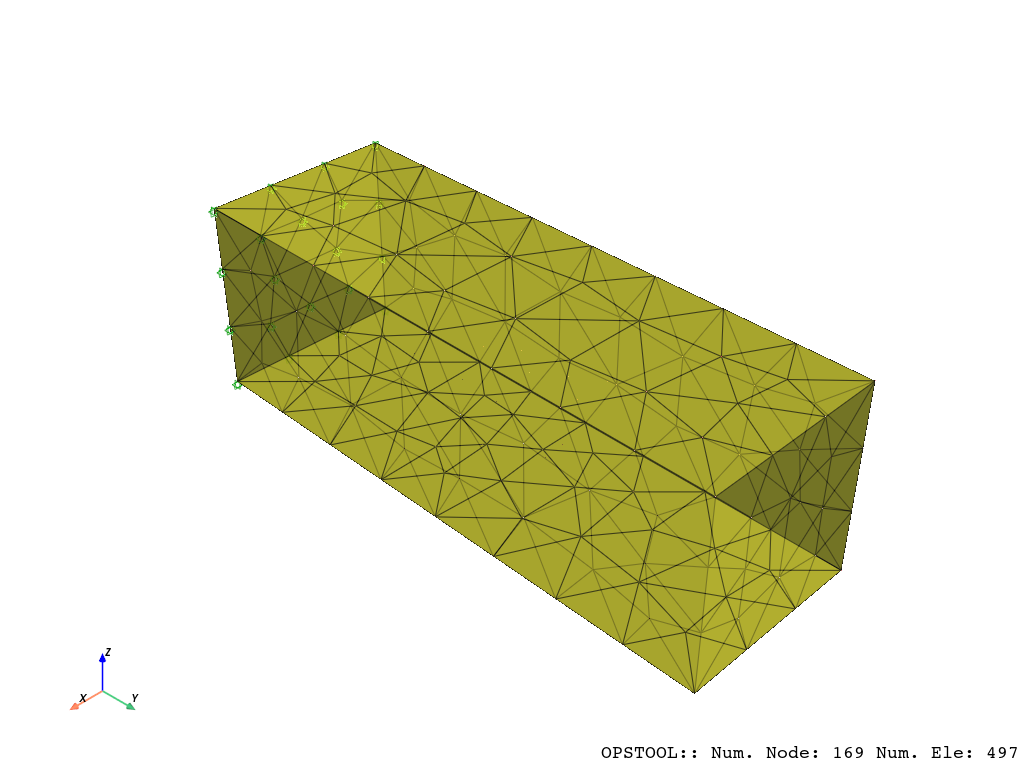

In [18]:
opst.vis.pyvista.set_plot_props(point_size=0, notebook=True, mesh_opacity=0.75)
plotter = opst.vis.pyvista.plot_model()
plotter.show(jupyter_backend="jupyterlab")
# plotter.show()

Using DomainModalProperties - Developed by: Massimo Petracca, Guido Camata, ASDEA Software Technology


OPSTOOL ::  Eigen data has been saved to _OPSTOOL_ODB/EigenData-None.nc!

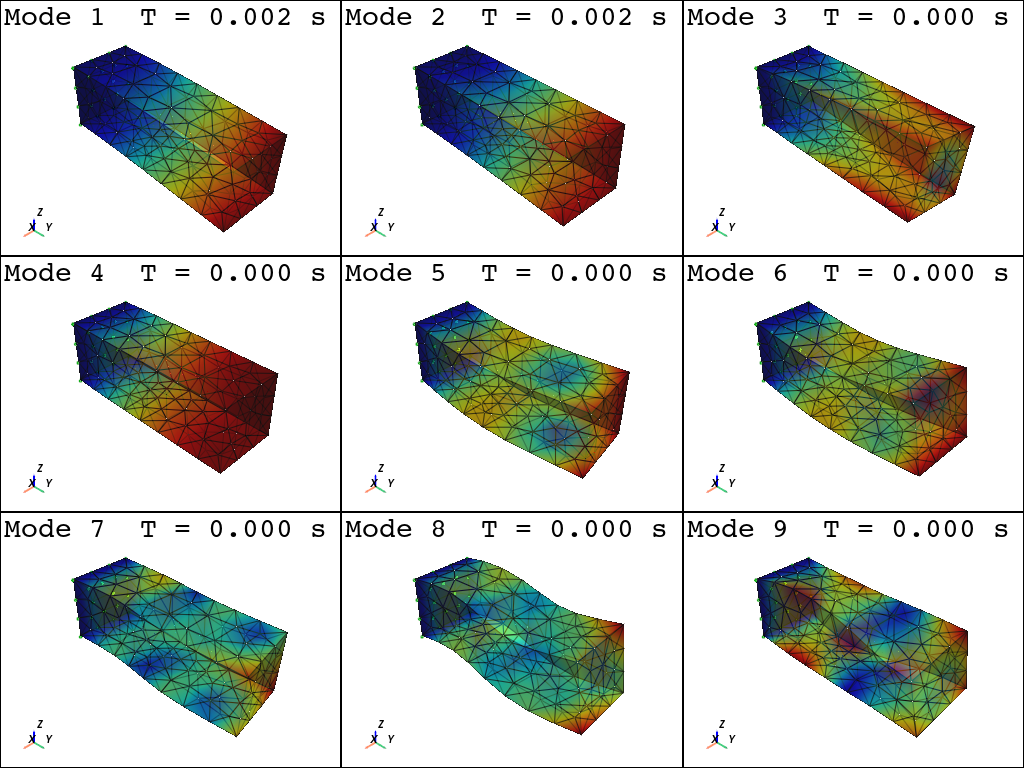

In [19]:
plotter = opst.vis.pyvista.plot_eigen([1, 9], subplots=True)
plotter.show(jupyter_backend="jupyterlab")
# plotter.show()